# Exercise 2

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.tools import input_factory, plot_tools

In [2]:
#parameters
MEMBRANE_TIME_SCALE_tau_s= 16 * b2.ms
MEMBRANE_CAPACITANCE_C_s = 370 * b2.pF
V_REST = -70.0 * b2.mV
ADAPTATION_TIME_CONSTANT_tau_w_s = 100.0 * b2.ms
V_RESET = -70.0 * b2.mV
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b = -200 * b2.pA
g_s = 1300 * b2.pA
ABSOLUTE_REFRACTORY_PERIOD = 3.0 * b2.ms
MEMBRANE_TIME_SCALE_tau_d= 8 * b2.ms
MEMBRANE_CAPACITANCE_C_d = 170 * b2.pF
ADAPTATION_TIME_CONSTANT_tau_w_d = 30.0 * b2.ms
V_DENDRITE = -38.0 * b2.mV
D_DENDRITE = 6.0 * b2.mV
a = -13.0 * b2.nS
g_d = 1200 * b2.pA
KERNEL_COEFFICIENT = 2600 * b2.pA
KERNEL_AMPLITUDE = 1
KERNEL_DELAY = 0.5 * b2.ms
KERNEL_DURATION = 2 * b2.ms

FIRING_THRESHOLD_v_spike = -50*b2.mV


In [3]:
def simulate_neuron(
        tau_s=MEMBRANE_TIME_SCALE_tau_s,
        C_s=MEMBRANE_CAPACITANCE_C_s,
        v_rest=V_REST,
        tau_w_s=ADAPTATION_TIME_CONSTANT_tau_w_s,
        I_s=input_factory.get_zero_current(),
        v_reset=V_RESET,
        b=SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b,
        g_s = g_s,
        v_spike=FIRING_THRESHOLD_v_spike,
        abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD,
        tau_d = MEMBRANE_TIME_SCALE_tau_d,
        C_d = MEMBRANE_CAPACITANCE_C_d,
        tau_w_d = ADAPTATION_TIME_CONSTANT_tau_w_d,
        I_d = input_factory.get_zero_current(),
        V_d = V_DENDRITE,
        D_d = D_DENDRITE,
        a = a,
        g = g_d,
        cd = KERNEL_COEFFICIENT,
        K_amp = KERNEL_AMPLITUDE,
        k_delay = KERNEL_DELAY,
        k_duration = KERNEL_DURATION,
        const_0 = 0*b2.Hz,
        
        simulation_time=200 * b2.ms):

    v_spike_str = "v_s>{:f}*mvolt".format(v_spike / b2.mvolt)

    # EXP-IF
    eqs = """
        dv_s/dt = -(v_s-v_rest)/tau_s + (I_s(t,i) + w_s + g_s*f)/C_s : volt (unless refractory)
        dw_s/dt= -w_s/tau_w_s : amp
        dv_d/dt = -(v_d-v_rest)/tau_d + (I_d(t,i) + w_d + g_d*f + cd*K)/C_d : volt
        dw_d/dt= (-w_d + a*(v_d-v_rest))/tau_w_d : amp
        f = 1/(1 + exp(-(v_d-V_d)/D_d)) : 1
        dtp/dt = 0 : second
        dK/dt = const_0 : 1
        """

    neuron = b2.NeuronGroup(1, model=eqs, threshold=v_spike_str, reset="v_s=v_reset;w_s+=b;tp=t", refractory=abs_refractory_period, method="euler",
                            events= {'activation': 't>tp+k_delay', 'deactivation' : 't>tp+k_delay+k_duration'})

    # initial values of v and w is set here:
    neuron.v_s = v_rest
    neuron.w_s = 0.0 * b2.pA
    neuron.v_d = v_rest
    neuron.w_d = 0.0 * b2.pA
    neuron.tp = -100 * b2.ms
    neuron.K = 0

    neuron.run_on_event('activation', 'K=K_amp')
    neuron.run_on_event('deactivation', 'K=0')

    # Monitoring membrane voltage (v) and w
    state_monitor = b2.StateMonitor(neuron, ["v_s", "w_s", "v_d", "w_d"], record = True)
    spike_monitor = b2.SpikeMonitor(neuron)
    activation_monitor = b2.EventMonitor(neuron, 'activation', ["K", "tp"], record = True)
    deactivation_monitor = b2.EventMonitor(neuron, 'deactivation')
    monitors = [state_monitor, spike_monitor, activation_monitor, deactivation_monitor]

    # running simulation
    hh_net = b2.Network(neuron)
    hh_net.add(monitors)
    hh_net.run(simulation_time)
    return state_monitor, spike_monitor, activation_monitor, deactivation_monitor


def get_EPSC_current(t_start, t_end, unit_time,
                    amplitude, decay_rate, append_zero=True):
    """Creates an EPSC-like current. If t_start == t_end, then ALL entries are 0.

    Args:
        t_start (int): start of the sine wave
        t_end (int): end of the sine wave
        unit_time (Quantity, Time): unit of t_start and t_end. e.g. 0.1*brian2.ms
        amplitude (Quantity, Current): maximum amplitude of the current e.g. 3.5*brian2.uamp
        decay_rate (Quantity, Time): decay rate e.g. 4.0*brian2.ms
        append_zero (bool, optional): if true, 0Amp is appended at t_end+1. Without that
            trailing 0, Brian reads out the last value in the array for all indices > t_end.


    Returns:
        TimedArray: Brian2.TimedArray
    """
    assert isinstance(t_start, int), "t_start_ms must be of type int"
    assert isinstance(t_end, int), "t_end must be of type int"
    assert b2.units.fundamentalunits.have_same_dimensions(amplitude, b2.amp), \
        "amplitude must have the dimension of current. e.g. brian2.uamp"
    assert b2.units.fundamentalunits.have_same_dimensions(decay_rate, b2.ms), \
        "decay_rate must have the dimension of time. e.g. brian2.ms"

    tmp_size = 1 + t_end  # +1 for t=0
    if append_zero:
        tmp_size += 1
    tmp = np.zeros((tmp_size, 1)) * b2.amp
    if t_end > t_start:  # if deltaT is zero, we return a zero current
        c = [amplitude * (1 - np.exp(-t/decay_rate)) * np.exp(-t/decay_rate)  for t in range(0, (t_end - t_start) + 1)*unit_time]
        tmp[t_start: t_end + 1, 0] = c
    curr = b2.TimedArray(tmp, dt=1. * unit_time)
    return curr


def plot_voltage_activation_and_current_traces(voltage_monitor, K_monitor, current_d, current_s, firing_threshold=None, title=None):
    """plots voltage and current .

    Args:
        voltage_monitor (StateMonitor): recorded voltage
        K_monitor (EventMonitor): recorded Kernel
        current_d (TimedArray): injected current in the dendrite
        current_s (TimedArray): injected current in the soma
        title (string, optional): title of the figure
        firing_threshold (Quantity, optional): if set to a value, the firing threshold is plotted.

    Returns:
        the figure
    """

    assert isinstance(voltage_monitor, b2.StateMonitor), "voltage_monitor is not of type StateMonitor"
    assert isinstance(K_monitor, b2.EventMonitor), "K_monitor is not of type EventMonitor"
    assert isinstance(current_d, b2.TimedArray), "current is not of type TimedArray"
    assert isinstance(current_s, b2.TimedArray), "current is not of type TimedArray"

    time_values_ms = voltage_monitor.t / b2.ms

    plt.figure(1, figsize=(14,8))

    # current
    axis_c = plt.subplot(221)
    c_d = current_d(voltage_monitor.t, 0)
    c_s = current_s(voltage_monitor.t, 0)
    max_current_d = max(current_d(voltage_monitor.t, 0))
    min_current_d = min(current_d(voltage_monitor.t, 0))
    max_current_s = max(current_s(voltage_monitor.t, 0))
    min_current_s = min(current_s(voltage_monitor.t, 0))
    margin = 1.05 * (max(max_current_d, max_current_s) - min(min_current_d, min_current_s))
    # plot the input current time-aligned with the voltage monitor
    plt.plot(voltage_monitor.t / b2.ms, c_d / b2.nA, "r", lw=2, label = 'dendrite')
    plt.plot(voltage_monitor.t / b2.ms, c_s / b2.nA, "orange", lw=2, label = 'soma')
    if margin > 0.:
        plt.ylim((min(min_current_d, min_current_s) - margin) / b2.nA, (max(max_current_d, max_current_s) + margin) / b2.nA)
    plt.xlabel("t [ms]")
    plt.ylabel("Input current [nA]")
    plt.grid()
    plt.legend()

    axis_k = plt.subplot(222)
    plt.plot(K_monitor.t / b2.ms, K_monitor.K, "grey", lw=2)
    max_val = max(K_monitor.K)
    min_val = min(K_monitor.K)
    margin = 0.05 * (max_val - min_val) 
    plt.ylim(min_val - margin, max_val + margin)
    plt.ylabel("Kernel value (no unit)")
    plt.xlabel("t [ms]")
    plt.grid()

    axis_v = plt.subplot(223)
    plt.plot(time_values_ms, voltage_monitor[0].v_s / b2.mV, "b", lw=2, label = 'soma')
    plt.plot(time_values_ms, voltage_monitor[0].v_d / b2.mV, "g", lw=2, label = 'dendrite')
    max_val_s = max(voltage_monitor[0].v_s)
    min_val_s = min(voltage_monitor[0].v_s)
    max_val_d = max(voltage_monitor[0].v_d)
    min_val_d = min(voltage_monitor[0].v_d)
    margin = 0.05 * (max(max_val_d, max_val_s) - min(min_val_s, min_val_d))
    plt.ylim((min(min_val_s, min_val_d) - margin) / b2.mV, (max(max_val_d, max_val_s) + margin) / b2.mV)
    if firing_threshold is not None:
        thresh = firing_threshold*np.ones((voltage_monitor.t.shape[0], 1))
        plt.plot(voltage_monitor.t / b2.ms, thresh / b2.mV, c = 'maroon',
            ls = "--", lw=1, label = 'firing threshold')
    plt.ylabel("membrane potential [mV]")
    plt.xlabel("t [ms]")
    plt.grid()
    plt.legend()


    axis_w = plt.subplot(224)
    plt.plot(time_values_ms, voltage_monitor[0].w_s / b2.nA, "b", lw=2, label = 'soma')
    plt.plot(time_values_ms, voltage_monitor[0].w_d / b2.nA, "g", lw=2, label = 'dendrite')
    plt.xlabel("t [ms]")
    plt.ylabel("adaptation [nA]")
    plt.xlabel("t [ms]")
    plt.grid()
    plt.legend()

    if title is not None:
        plt.suptitle(title)
    plt.show()
    return axis_c, axis_v, axis_w, axis_k

## Question 2.1

clang-14: error: the clang compiler does not support '-march=native'
WARNING    Cannot use Cython, a test compilation failed: command '/Users/oliviaruggaber/miniconda3/envs/bmnn/bin/arm64-apple-darwin20.0.0-clang' failed with exit code 1 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


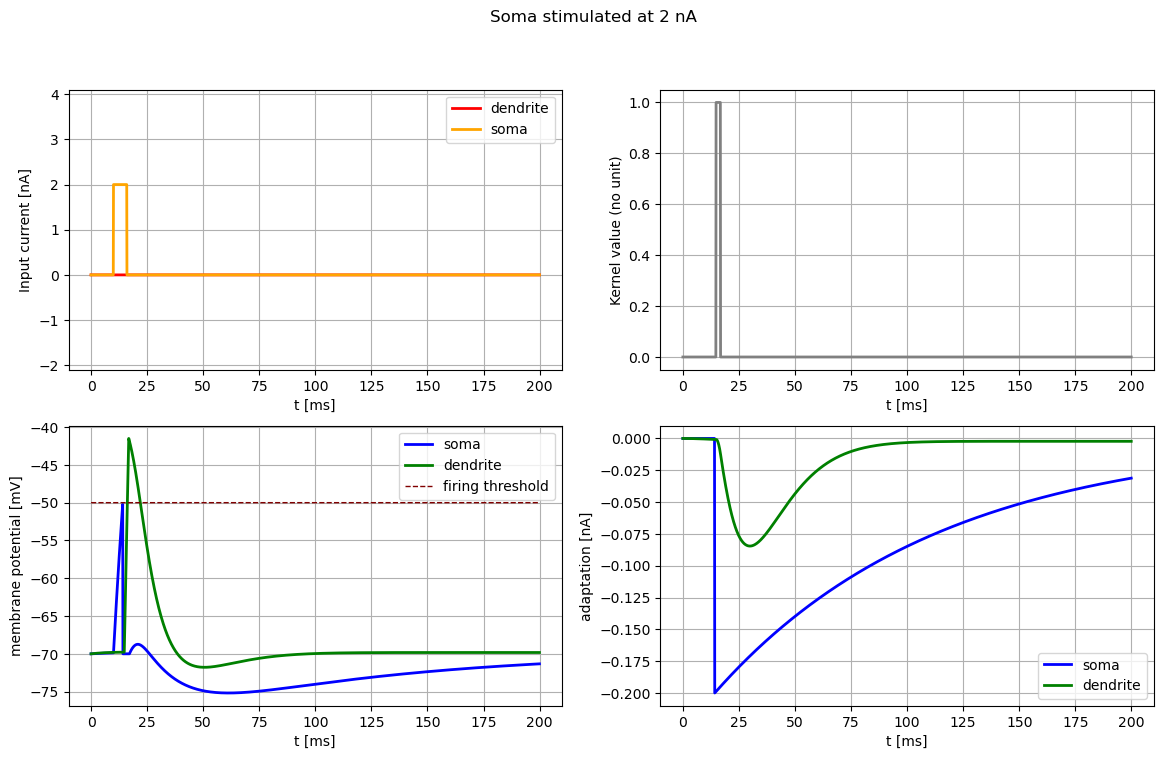

(<Axes: xlabel='t [ms]', ylabel='Input current [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='membrane potential [mV]'>,
 <Axes: xlabel='t [ms]', ylabel='adaptation [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='Kernel value (no unit)'>)

In [4]:
current_step = input_factory.get_step_current(10, 15, b2.ms, 2*b2.nA)
state_monitor, spike_monitor, activation_monitor, deactivation_monitor = simulate_neuron(I_s = current_step, I_d = input_factory.get_zero_current())
plot_voltage_activation_and_current_traces(state_monitor, activation_monitor, input_factory.get_zero_current(), current_step, 
                                           firing_threshold = FIRING_THRESHOLD_v_spike, title='Soma stimulated at 2 nA')

## Question 2.2

WARNING    /var/folders/vf/crff2gv97cs_b8t0fhjvy6800000gn/T/ipykernel_50847/3545878020.py:151: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(min_val - margin, max_val + margin)
 [py.warnings]


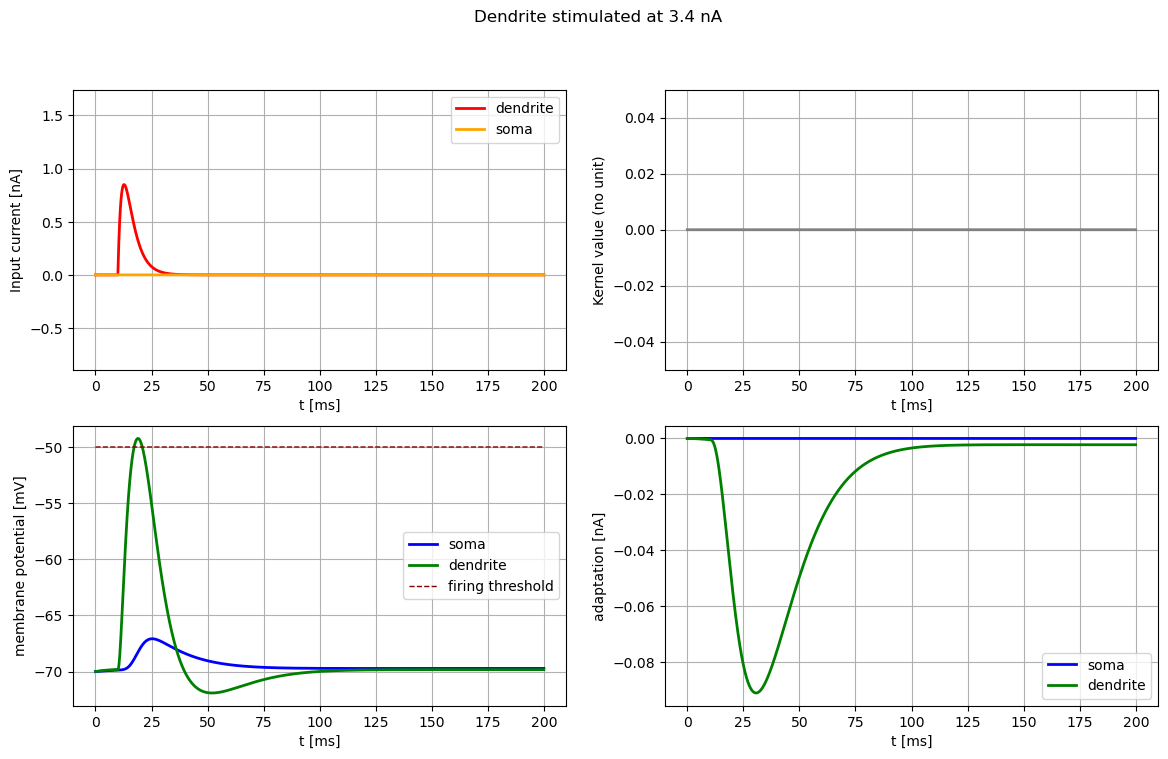

(<Axes: xlabel='t [ms]', ylabel='Input current [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='membrane potential [mV]'>,
 <Axes: xlabel='t [ms]', ylabel='adaptation [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='Kernel value (no unit)'>)

In [5]:
current_epsc = get_EPSC_current(100, 1100, 0.1*b2.ms, 3.4*b2.nA, 4*b2.ms)
current_zero = input_factory.get_zero_current()
state_monitor, spike_monitor, activation_monitor, deactivation_monitor = simulate_neuron(I_s = current_zero, I_d = current_epsc)
plot_voltage_activation_and_current_traces(state_monitor, activation_monitor, current_epsc, current_zero,
                                            firing_threshold = FIRING_THRESHOLD_v_spike, title='Dendrite stimulated at 3.4 nA')

## Question 2.3

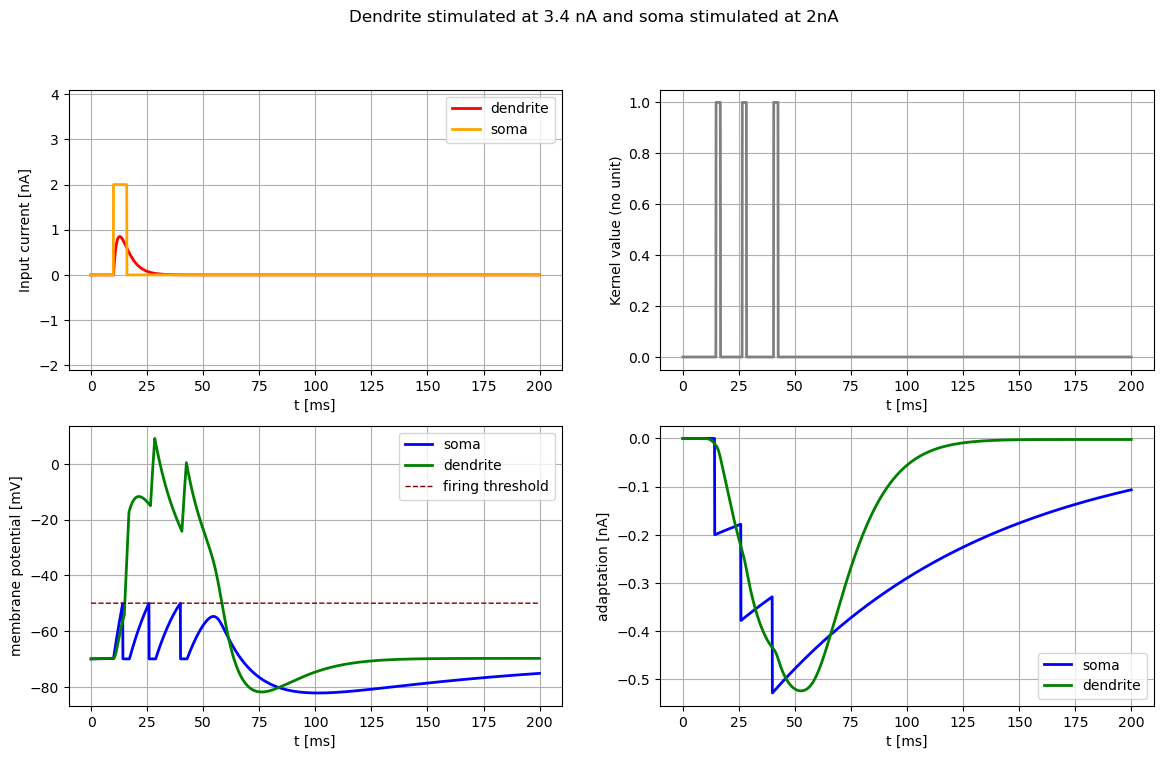

(<Axes: xlabel='t [ms]', ylabel='Input current [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='membrane potential [mV]'>,
 <Axes: xlabel='t [ms]', ylabel='adaptation [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='Kernel value (no unit)'>)

In [6]:
current_epsc = get_EPSC_current(100, 1100, 0.1*b2.ms, 3.4*b2.nA, 4*b2.ms)
current_step = input_factory.get_step_current(10, 15, b2.ms, 2*b2.nA)
state_monitor, spike_monitor, activation_monitor, deactivation_monitor = simulate_neuron(I_s = current_step, I_d = current_epsc)
plot_voltage_activation_and_current_traces(state_monitor, activation_monitor, current_epsc, current_step,
                                            firing_threshold = FIRING_THRESHOLD_v_spike, title='Dendrite stimulated at 3.4 nA and soma stimulated at 2nA')

## Question 2.4

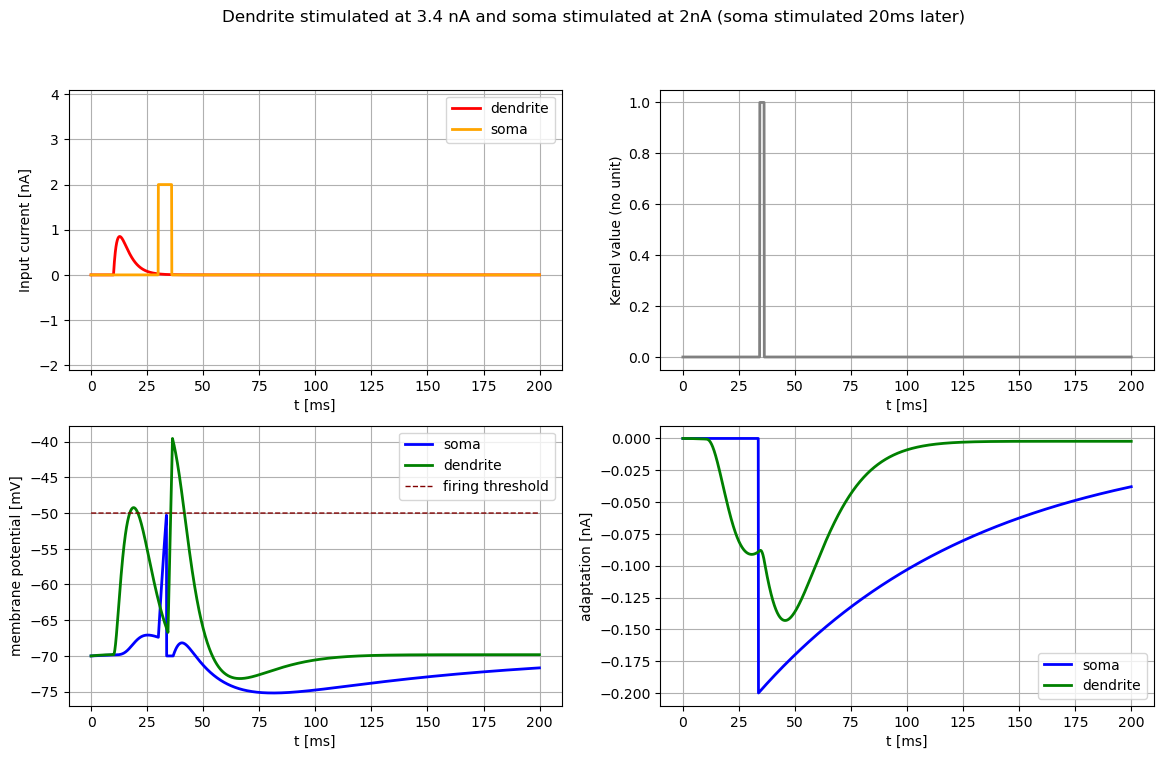

(<Axes: xlabel='t [ms]', ylabel='Input current [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='membrane potential [mV]'>,
 <Axes: xlabel='t [ms]', ylabel='adaptation [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='Kernel value (no unit)'>)

In [7]:
current_epsc = get_EPSC_current(100, 1100, 0.1*b2.ms, 3.4*b2.nA, 4*b2.ms)
current_step = input_factory.get_step_current(30, 35, b2.ms, 2*b2.nA)
state_monitor, spike_monitor, activation_monitor, deactivation_monitor = simulate_neuron(I_s = current_step, I_d = current_epsc)
plot_voltage_activation_and_current_traces(state_monitor, activation_monitor, current_epsc, current_step,
                                            firing_threshold = FIRING_THRESHOLD_v_spike, title='Dendrite stimulated at 3.4 nA and soma stimulated at 2nA (soma stimulated 20ms later)')